<a href="https://colab.research.google.com/github/Santosh344/RetaildataAnalysis/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing liberries... 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#fb prophet imports...
#fb prophet imports..... 
import fbprophet
from fbprophet import Prophet
from fbprophet.plot import (plot_plotly, 
                            plot_components_plotly,
                            plot_forecast_component)

#should be version 0.6+
fbprophet.__version__

'0.7.1'

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#importing data...
#df = pd.read_csv('C:/Users/Admin/Desktop/thesis/train.csv')

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/6/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
#dropping unwanted row....
df.drop(['Row ID','Customer ID','Customer Name','Product ID','Product Name'], axis = 1, inplace = True)

In [ ]:
df = df.sort_values('Order Date')
df = df.groupby('Order Date')['Sales'].sum().reset_index()
df.head()

,Order Date,Sales
0,1/1/2018,1481.828
1,1/10/2015,4.710
2,1/10/2016,1158.414
3,1/10/2017,781.414
4,1/10/2018,2978.466


In [ ]:
df = df.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
df = df[:int(df.shape[0])]
df

,ds,y
0,1/1/2018,1481.828
1,1/10/2015,4.710
2,1/10/2016,1158.414
3,1/10/2017,781.414
4,1/10/2018,2978.466
...,...,...
1225,9/8/2016,4878.392
1226,9/8/2017,661.354
1227,9/9/2015,4043.588
1228,9/9/2017,84.992


In [ ]:
#the data has been prepared as per the model prophet requirement. so lets try out model to forecast for next one year.....
m = Prophet(interval_width=0.95, daily_seasonality=False)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
#making predictionof next one year
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1590,2019-12-26
1591,2019-12-27
1592,2019-12-28
1593,2019-12-29
1594,2019-12-30


In [ ]:
#forecasting for one year....
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1590,2019-12-26,2520.174968,-840.277908,7913.874835,2511.840530,2529.211836,819.572156,819.572156,819.572156,-211.867131,-211.867131,-211.867131,1031.439287,1031.439287,1031.439287,0.0,0.0,0.0,3339.747123
1591,2019-12-27,2520.861324,-1105.270972,7842.205204,2512.500750,2529.941325,974.982441,974.982441,974.982441,-98.374966,-98.374966,-98.374966,1073.357406,1073.357406,1073.357406,0.0,0.0,0.0,3495.843765
1592,2019-12-28,2521.547681,-491.994680,8149.948426,2513.146636,2530.664693,1392.069359,1392.069359,1392.069359,291.848557,291.848557,291.848557,1100.220802,1100.220802,1100.220802,0.0,0.0,0.0,3913.617040
1593,2019-12-29,2522.234037,-677.564593,7664.275746,2513.778616,2531.365321,1007.215988,1007.215988,1007.215988,-103.788878,-103.788878,-103.788878,1111.004866,1111.004866,1111.004866,0.0,0.0,0.0,3529.450025
1594,2019-12-30,2522.920394,-578.651950,7993.009625,2514.410596,2532.065948,1150.253054,1150.253054,1150.253054,45.172027,45.172027,45.172027,1105.081027,1105.081027,1105.081027,0.0,0.0,0.0,3673.173448


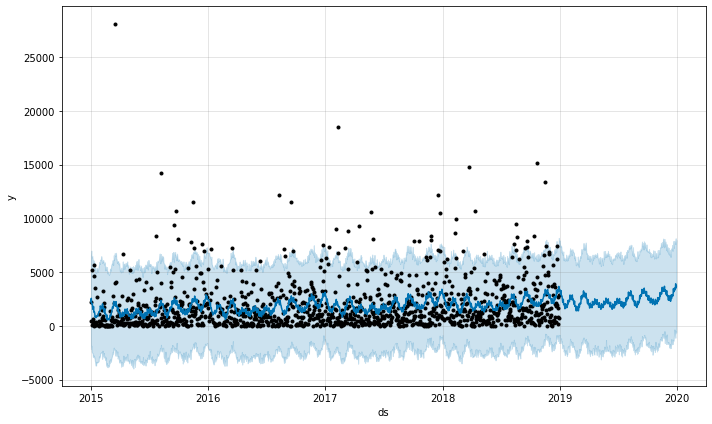

In [ ]:
fig1 = m.plot(forecast)

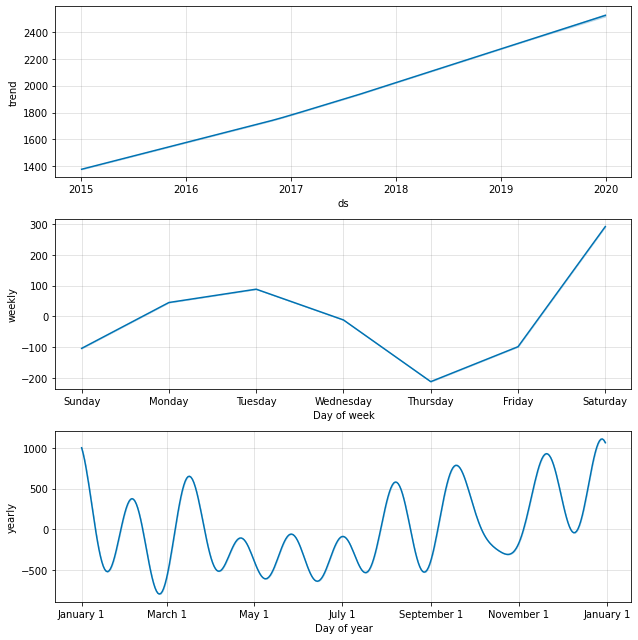

In [ ]:
fig2 = m.plot_components(forecast)


In [ ]:
m = Prophet(interval_width = 0.95)
m.add_country_holidays(country_name='US')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
m.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

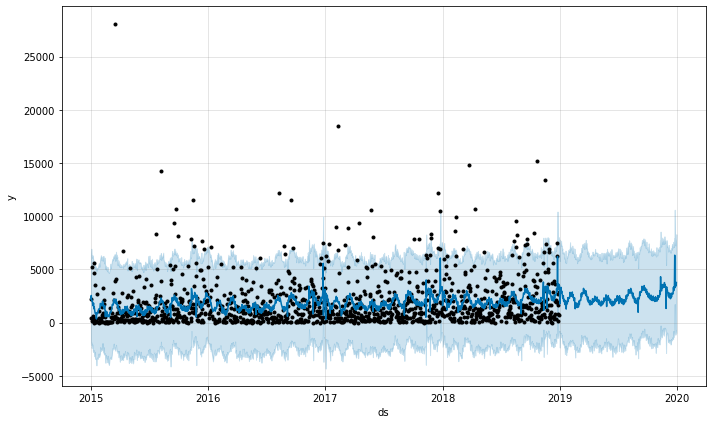

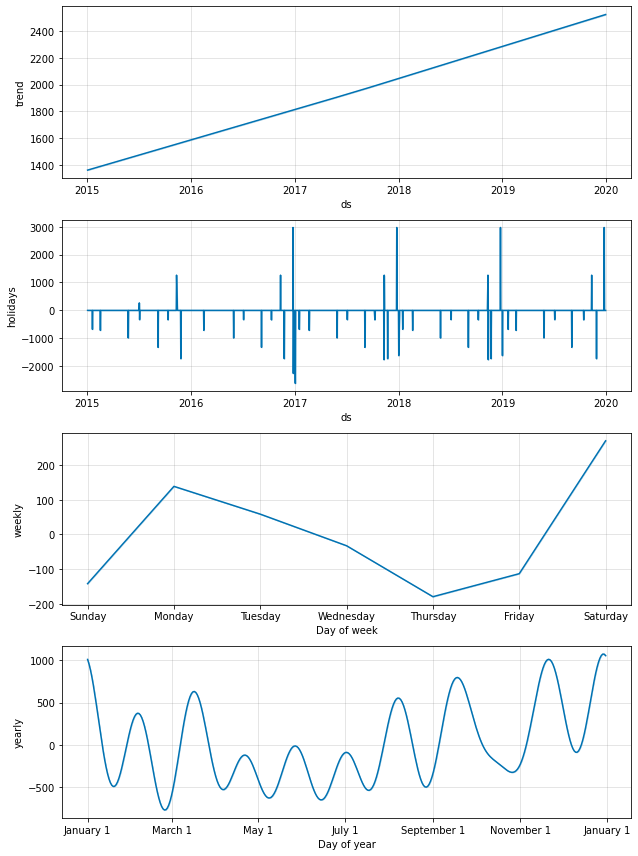

In [ ]:
forecast = m.predict(future)
m.plot(forecast)
fig = m.plot_components(forecast)

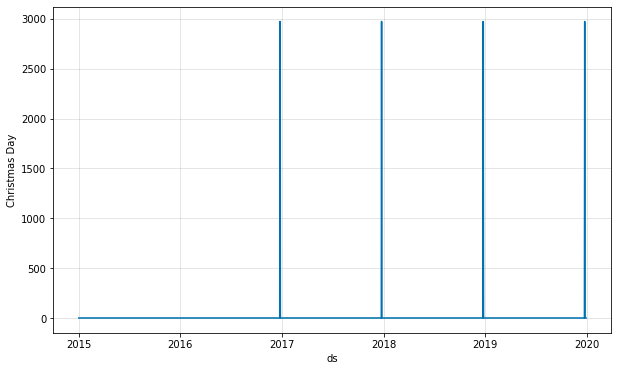

In [ ]:
#lets check individual holiday effect.....
plot_forecast_component(m, forecast, 'Christmas Day');

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


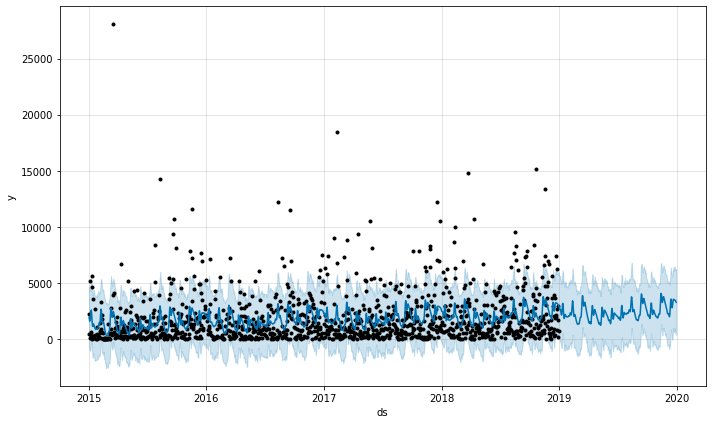

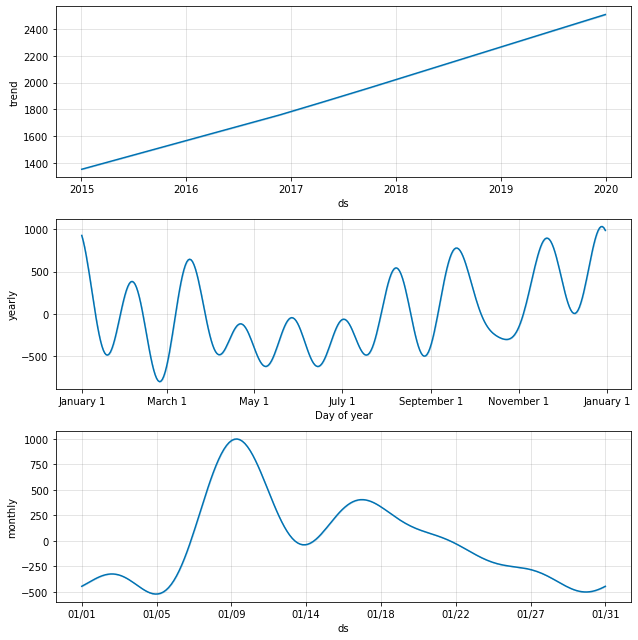

In [ ]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
m.plot(forecast)
fig = m.plot_components(forecast)

In [ ]:
#checking seasonality with respect to other factor...
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


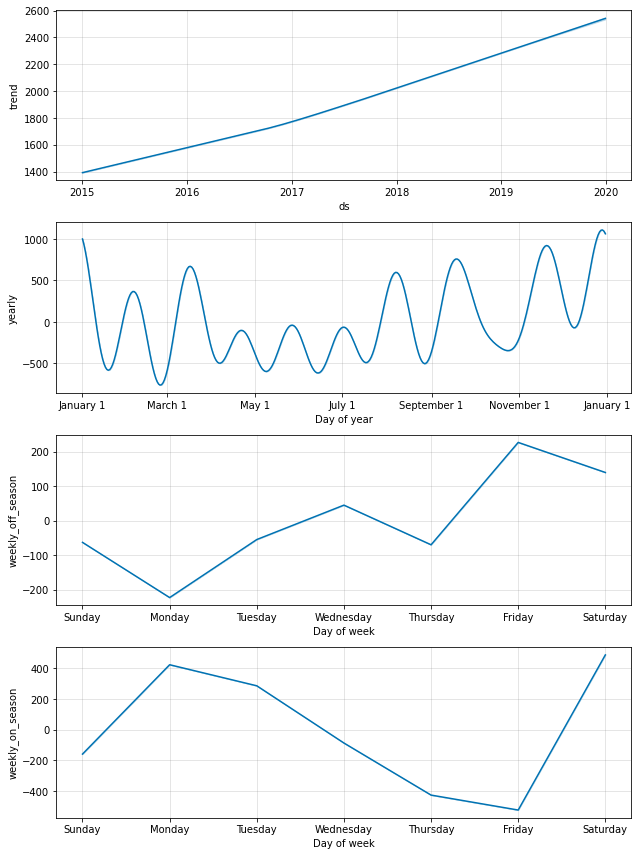

In [ ]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


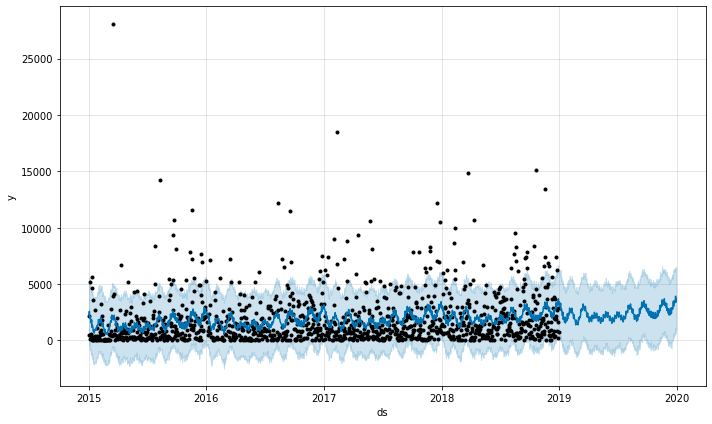

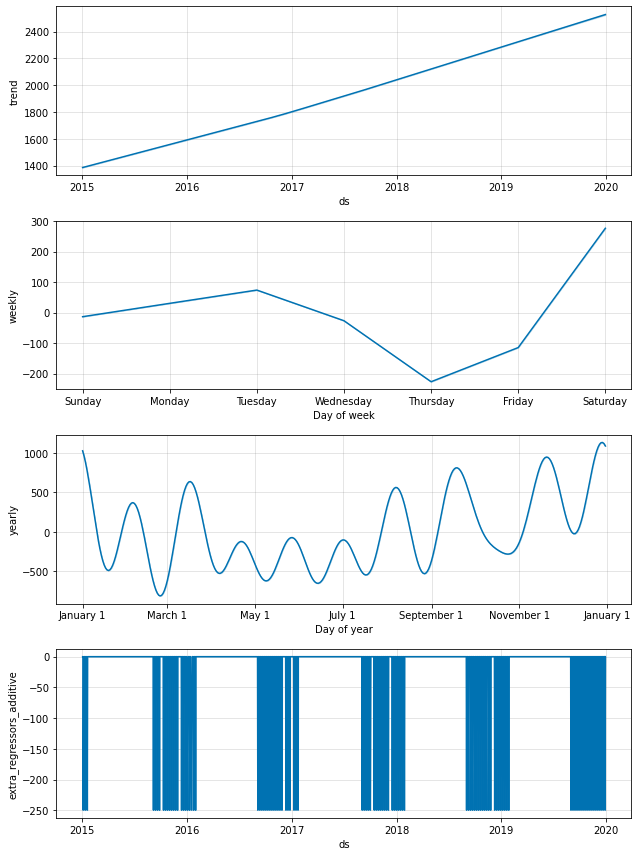

In [ ]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot(forecast)
fig = m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730', period='180 days', horizon = '365 days')


INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-15 00:00:00 and 2017-12-30 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


In [ ]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
2134,2018-12-26,3570.798331,1020.444192,6635.089505,814.5940,2017-12-30
2135,2018-12-27,3275.558666,445.837116,5960.146957,177.6360,2017-12-30
2136,2018-12-28,3068.893123,428.318062,5944.756549,1657.3508,2017-12-30
2137,2018-12-29,3513.448562,608.299043,6345.576099,2915.5340,2017-12-30
2138,2018-12-30,3433.941760,770.300703,6115.036231,713.7900,2017-12-30


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
320,361 days,5.343367e+07,7309.833812,3600.650333,12.199589,0.805978,0.756539
321,362 days,5.707324e+07,7554.683395,3694.460736,12.011471,0.778965,0.747418
322,363 days,6.014401e+07,7755.256703,3763.108356,11.952764,0.768750,0.750235
323,364 days,5.955552e+07,7717.222427,3724.695613,11.278144,0.768750,0.748826
324,365 days,5.876075e+07,7665.556373,3700.135231,10.674163,0.768750,0.739101


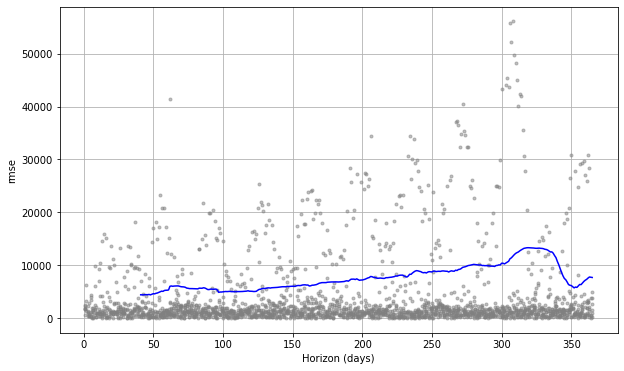

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')